In [2]:
from __future__ import print_function
import os, sys
import time
import pickle
from copy import copy
import pandas as pd
import numpy as np
import h5py
import datetime
from datetime import datetime
from data_constructor import Dataset_constructor
# from timestamp import timestamp2vec
from MaxMin_Norm import MinMaxNormalization
from chinese_calendar import is_holiday
from timestamp import string2timestamp
DATAPATH = 'data/'

In [5]:
def timestamp2vec(timestamps,timestamps_W):
    """
    :param timestamps:
    :return:
    exampel:
    [b'2018120505', b'2018120106']
    #[[0 0 1 0 0 0 0 1]  
     [0 0 0 0 0 1 0 0]]  
    
    """
    vac = [time.strptime(str(t[:8],encoding='utf-8'), '%Y%m%d').tm_wday for t in timestamps]  # python3
    # vec = [time.strptime(t[:8], '%Y%m%d').tm_wday for t in timestamps]  # python2
    rat = []
    for i in vac:
        w = [0 for _ in range(7)]
        w[i] = 1
        if i >= 5:
            w.append(0)  # weekend
        else:
            w.append(1)  # weekday
        rat.append(w)
    # tm_wday range [0, 6], Monday is 0
#     vec = [time.strptime(str(t[:8],encoding='utf-8'), '%Y%m%d').tm_wday for t in timestamps]
    ret1 = []
#     for i in vec:
#         v = [0 for _ in range(7)]
#         v[i] = 1
#         if i >= 5:
#             v.append(0)  # weekend
#         else:
#             v.append(1)  # weekday
#         ret.append(v)
    
#     return np.asarray(ret)
    for timestamp in timestamps_W:
        vec = [time.strptime(str(t[:8],encoding='utf-8'), '%Y%m%d').tm_wday for t in timestamp]  # python3
        # vec = [time.strptime(t[:8], '%Y%m%d').tm_wday for t in timestamps]  # python2
        ret =[]
        for i in vec:
            v = [0 for _ in range(7)]
            v[i] = 1
            if i >= 5:
                v.append(0)  # weekend
            else:
                v.append(1)  # weekday
            ret.append(v)
        ret1.append(ret)
    return np.asarray(rat),np.asarray(ret1)
class Dataset_constructor(object):

    def __init__(self, data, timestamps, T=48, CheckComplete=True):
        super(Dataset_constructor, self).__init__()
        assert len(data) == len(timestamps)
        self.data = data
        self.timestamps = timestamps# [b'2013070101', b'2013070102']
        self.T = T
        self.pd_timestamps = string2timestamp(timestamps, T=self.T)
        self.make_index()  # 将时间戳：做成一个字典，也就是给每个时间戳一个序号

    def make_index(self):
        self.get_index = dict()
        for i, ts in enumerate(self.pd_timestamps):
            self.get_index[ts] = i
            
    def get_matrix(self, timestamp):  # 给定时间戳返回对于的数据
        return self.data[self.get_index[timestamp]]

    def check_it(self, depends):
        for d in depends:
            if d not in self.get_index.keys():
                return False
        return True
    
    def create_dataset(self, c_length=6, t_length=3, t_inter=7, p_length=1, p_inter=1):
        offset_frame = pd.DateOffset(minutes=24 * 60 // self.T)  # 时间偏移 minutes = 30
        C_list = []
        P_list = []
        T_list = []
        Y_list = []
        timestamps_Y = []
        timestamps_X=[]
        timestamps_W = []
        time_range = [[10,9,8,7,6,5],
                      [49,48,47],
#                       [p_inter * self.T * j for j in range(1, p_length +1)],
                      [337,336,335]]
#                       [t_inter * self.T * j for j in range(1, t_length + 1)]]

        # print depends # [range(1, 4), [48, 96, 144], [336, 672, 1008]]
#         print(self.pd_timestamps)
        
        bound = max(self.T * t_inter * t_length+1, self.T * p_inter * p_length, c_length)
        print(self.T * t_inter * t_length)
        print(bound)
        while bound < len(self.pd_timestamps):
            Flag = True
            for branch in time_range:
                if Flag is False:
                    break
                Flag = self.check_it([self.pd_timestamps[bound] - j * offset_frame for j in branch])

            if Flag is False:
                bound += 1
                continue
            x_c = [self.get_matrix(self.pd_timestamps[bound] - j * offset_frame) for j in time_range[0]]
            # 取当前时刻的前3个时间片的数据数据构成“邻近性”模块中一个输入序列
            # 例如当前时刻为[Timestamp('2013-07-01 00:00:00')]
            # 则取：

#             [Timestamp('2013-06-30 23:30:00'), Timestamp('2013-06-30 23:00:00'), Timestamp('2013-06-30 22:30:00')]
#             #  三个时刻所对应的in-out flow为一个序列
            x_p = [self.get_matrix(self.pd_timestamps[bound] - j * offset_frame) for j in time_range[1]]
#             # 取当前时刻 前 1*PeriodInterval,2*PeriodInterval,...,len_period*PeriodInterval
#             # 天对应时刻的in-out flow 作为一个序列，例如按默认值为 取前1、2、3天同一时刻的In-out flow
            x_t = [self.get_matrix(self.pd_timestamps[bound] - j * offset_frame) for j in time_range[2]]
            # 取当前时刻 前 1*TrendInterval,2*TrendInterval,...,len_trend*TrendInterval
            # 天对应时刻的in-out flow 作为一个序列,例如按默认值为 取 前7、14、21天同一时刻的In-out flow
            y = self.get_matrix(self.pd_timestamps[bound])
            if c_length > 0:
                C_list.append(np.vstack(x_c))
                # a.shape=[2,32,32] b.shape=[2,32,32] c=np.vstack((a,b)) -->c.shape = [4,32,32]
            if p_length > 0:
                P_list.append(np.vstack(x_p))
            if t_length > 0:
                T_list.append(np.vstack(x_t))
            Y_list.append(y)
            timestamps_Y.append(self.timestamps[bound])
            timestamps_X.append(self.timestamps[bound-24])
            timestamps_W.append([self.timestamps[bound-j] for j in [6,5,4,3,2,1]])
            bound+=1
#             print(timestamps_Y)                
#         print(count)
#         print(dasasf)
#         print(timestamps_Y)
#         np.save('te.npy', XC_train)
        XC = np.asarray(C_list)  # 模拟 邻近性的 数据 [?,6,32,32]
        XP = np.asarray(P_list)  # 模拟 周期性的 数据 隔天
        XT = np.asarray(T_list)  # 模拟 趋势性的 数据 隔周
        Y = np.asarray(Y_list)# [?,2,32,32]
# 
        print("XC shape: ", XC.shape, "XP shape: ", XP.shape, "XT shape: ", XT.shape, "Y shape:", Y.shape)
        return XC, XP, XT, Y, timestamps_Y,timestamps_X,timestamps_W
#         return timestamps_Y

In [6]:
def load_holiday(timeslots,timestamps_W, fname=os.path.join(DATAPATH, 'BJ_Holiday.txt')):
    """
    载入假期数据
    :param timeslots:
    :param fname:
    :return:
    [[1],[1],[0],[0],[0]...] 当前时间片对应为假期则为1

    """

    f = open(fname, 'r')
    holidays = f.readlines()
    holidays = set([h.strip() for h in holidays])
    H1 = []
    
#     H = np.zeros(len(timeslots))
    for timeslot in timestamps_W:
        H = np.zeros(len(timeslot))
        for i, slot in enumerate(timeslot):
            slot = str(slot, encoding="utf-8")
            slot = datetime.strptime(slot[:8],'%Y%m%d')
            if is_holiday(slot):
                H[i] = 1
        H1.append(H)
    H1 = np.asarray(H1)
    H1 = H1.reshape(14969,6,1)
#         if slot[:8] in holidays:
#             H[i] = 1
    # print(timeslots[H==1])
    H = np.zeros(len(timeslots))
    for i, slot in enumerate(timeslots):
        slot = str(slot, encoding="utf-8")
        slot = datetime.strptime(slot[:8],'%Y%m%d')
        if is_holiday(slot):
            H[i] = 1
#         if slot[:8] in holidays:
#             H[i] = 1
    # print(timeslots[H==1])
    return H[:, None],H1  # 变成2维
#     H = np.zeros(len(timeslots))
#     W = np.zeros(len(timeslots))
#     Z = np.zeros(len(timeslots))
#     for i, slot in enumerate(timeslots):
#         slot = str(slot, encoding="utf-8")
#         slot = datetime.strptime(slot[:8],'%Y%m%d')
#         if is_holiday(slot):
#             H[i] = 1
#         if slot>=X and slot<=Y:
# #             print(1)
#             W[i] = 1
# #         if slot[:8] in holidays:
# #             H[i] = 1
#     # print(timeslots[H==1])
#     return np.concatenate((H[:, None],W[:, None]),axis=1)  # 变成2维

In [7]:
def load_meteorol(timeslots,timeslots_w, fname=os.path.join(DATAPATH, 'BJ_Meteorology.h5')):
    '''
    timeslots: the predicted timeslots
    In real-world, we dont have the meteorol data in the predicted timeslot, instead, we use the meteoral at previous timeslots, i.e., slot = predicted_slot - timeslot (you can use predicted meteorol data as well)
    气象数据
    '''
    WS1 = []
    WR1 = []
    TE1 = [] 
    f = h5py.File(fname, 'r')
    Timeslot = f['date'][()]#.value
    WindSpeed = f['WindSpeed'][()]#.value
    Weather = f['Weather'][()]#.value
    Temperature = f['Temperature'][()]#.value
    f.close()
    
    M = dict()  # map timeslot to index
    for i, slot in enumerate(Timeslot):
        M[slot] = i
    WS2 = []  # WindSpeed
    WR2 = []  # Weather
    TE2 = []  # Temperature
    for slot in timeslots:
        predicted_id = M[slot]
        cur_id = predicted_id - 1
        WS2.append(WindSpeed[cur_id])
        WR2.append(Weather[cur_id])
        TE2.append(Temperature[cur_id])

    WS2 = np.asarray(WS2)
    WR2 = np.asarray(WR2)
    TE2 = np.asarray(TE2)

    # 0-1 scale
    WS2 = 1. * (WS2 - WS2.min()) / (WS2.max() - WS2.min())
    TE2 = 1. * (TE2 - TE2.min()) / (TE2.max() - TE2.min())

    print("meteorol shape: ", WS2.shape, WR2.shape, TE2.shape)

    # concatenate all these attributes
    merge_data1 = np.hstack([WR2, WS2[:, None], TE2[:, None]])

    print('meger shape:', merge_data1.shape)
    
    for timeslot in timeslots_w:
        WS = []  # WindSpeed
        WR = []  # Weather
        TE = []  # Temperature
        for slot in timeslot:
            predicted_id = M[slot]
            cur_id = predicted_id 
            WS.append(WindSpeed[cur_id])
            WR.append(Weather[cur_id])
            TE.append(Temperature[cur_id])
            
        WS1.append(WS)
        WR1.append(WR)
        TE1.append(TE)
    WS1 = np.asarray(WS1)
    WR1 = np.asarray(WR1)
    TE1 = np.asarray(TE1)
    # 0-1 scale
    WS1 = 1. * (WS1 - WS1.min()) / (WS1.max() - WS1.min())
    TE1 = 1. * (TE1 - TE1.min()) / (TE1.max() - TE1.min())

    print("meteorol shape: ", WS1.shape, WR1.shape, TE1.shape)
    WS1 = WS1.reshape(14969,6,1)
    TE1 = TE1.reshape(14969,6,1)
    # concatenate all these attributes
    merge_data = np.concatenate((WR1, WS1, TE1),axis=2)

    print('meger shape:', merge_data.shape)
    return merge_data1,merge_data

In [8]:
def load_stdata(fname):
    """
    split the data and date(timestamps)
    :param fname:
    :return:
    """
    l = []
    count = 0 
    f = h5py.File(fname, 'r')
    data = f['data'][:]
    timestamps = f['date'][:]
#     for j,i in enumerate(timestamps):
#         if i[:8] == b'20160209':
#             count +=1
#             timestamps = np.delete(timestamps, np.where(timestamps == i))
#             l.append(j)
#     if count>10:
#         data = np.delete(data, l,axis=0)
#     print(len(data))
#     print(len(timestamps))
    f.close()
    return data, timestamps

In [9]:
def stat(fname):
    """
    count the valid data
    :param fname:
    :return: like below

    ==========stat==========
    data shape: (7220, 2, 32, 32)
    # of days: 162, from 2015-11-01 to 2016-04-10
    # of timeslots: 7776
    # of timeslots (available): 7220
    missing ratio of timeslots: 7.2%
    max: 1250.000, min: 0.000
    ==========stat==========

    """

    def get_nb_timeslot(f):
        """
        count the number of timeslot of given data
        :param f:
        :return:
        """
        s = f['date'][0]
        e = f['date'][-1]
        year, month, day = map(int, [s[:4], s[4:6], s[6:8]])
        ts = time.strptime("%04i-%02i-%02i" % (year, month, day), "%Y-%m-%d")
        year, month, day = map(int, [e[:4], e[4:6], e[6:8]])
        te = time.strptime("%04i-%02i-%02i" % (year, month, day), "%Y-%m-%d")
        nb_timeslot = (time.mktime(te) - time.mktime(ts)) / (0.5 * 3600) + 48
        time_s_str, time_e_str = time.strftime("%Y-%m-%d", ts), time.strftime("%Y-%m-%d", te)
        return nb_timeslot, time_s_str, time_e_str

    with h5py.File(fname) as f:
        nb_timeslot, time_s_str, time_e_str = get_nb_timeslot(f)
        nb_day = int(nb_timeslot / 48)
        mmax = f['data'][:].max()
        mmin = f['data'][:].min()
        stat = '=' * 10 + 'stat' + '=' * 10 + '\n' + \
               'data shape: %s\n' % str(f['data'].shape) + \
               '# of days: %i, from %s to %s\n' % (nb_day, time_s_str, time_e_str) + \
               '# of timeslots: %i\n' % int(nb_timeslot) + \
               '# of timeslots (available): %i\n' % f['date'].shape[0] + \
               'missing ratio of timeslots: %.1f%%\n' % ((1. - float(f['date'].shape[0] / nb_timeslot)) * 100) + \
               'max: %.3f, min: %.3f\n' % (mmax, mmin) + \
               '=' * 10 + 'stat' + '=' * 10
        print(stat)

In [10]:
def remove_incomplete_days(data, timestamps, T=48):
    """
    remove a certain day which has not 48 timestamps
    :param data:
    :param timestamps:
    :param T:
    :return:
    """
    days = []  # available days: some day only contain some seqs
    days_incomplete = []
    i = 0
    while i < len(timestamps):
        if int(timestamps[i][8:]) != 1:
            i += 1
        elif i + T - 1 < len(timestamps) and int(timestamps[i + T - 1][8:]) == T:
            days.append(timestamps[i][:8])
            i += T
        else:
            days_incomplete.append(timestamps[i][:8])
            i += 1
    print("incomplete days: ", days_incomplete)
    days = set(days)
    idx = []
    for i, t in enumerate(timestamps):
        if t[:8] in days:
            idx.append(i)

    data = data[idx]
    timestamps = [timestamps[i] for i in idx]
    return data, timestamps

In [12]:
def load_dataset(T=48, flow_channel=2, c_length=None,
                 p_length=None, t_length=None, test_len=None, val_len=None, 
                 meta_data=True,meteorol_data=True, holiday_data=True):
    #assert (len_closeness + len_period + len_trend > 0)
    # load data
    # 13 - 16
#     self.create_data = create_data()
    data_all = []
    timestamps_all = list()
    for year in range(13, 17):
        fname = os.path.join(
            DATAPATH, 'BJ{}_M32x32_T30_InOut.h5'.format(year))
        print("file name: ", fname)
        stat(fname)
        data, timestamps = load_stdata(fname)
        print(timestamps)
        # remove a certain day which does not have 48 timestamps
        data, timestamps = remove_incomplete_days(data, timestamps, T)
        data = data[:, :flow_channel]
        data[data < 0] = 0.
        data_all.append(data)
   
    
        timestamps_all.append(timestamps)
        print("\n")
    # minmax_scale
    data_train = np.vstack(copy(data_all))[:-(test_len+ val_len)]
    print('train_data shape: ', data_train.shape)

    scale = MinMaxNormalization()
    scale.fit(data_train)
    data_scale = [scale.transform(d) for d in data_all]
    scale_pkl = open(os.path.join(DATAPATH, 'preprocessing.pkl'), 'wb')
    for item in [scale]:
        pickle.dump(item, scale_pkl)  # 保存特征缩放模型[-1,1]
    scale_pkl.close()
#     print(len(data_all_mmn[0]))
    print(timestamps_all[0][:10])
    XC, XP, XT = [], [], []
    Y = []
    timestamps_Y = []
    timestamps_X = []
    timestamps_W = []
#     print(len(data_scale[0]))
#     print(dafdfa)
    for data, timestamps in zip(data_scale, timestamps_all):
        data_func = Dataset_constructor(data, timestamps, T, CheckComplete=False)
        c_item, p_item, t_item, y_item,time_item,time_item_x,time_item_w = data_func.create_dataset(
            c_length=c_length, p_length=p_length, t_length=t_length)
        XC.append(c_item)
        XP.append(p_item)
        XT.append(t_item)
        Y.append(y_item)
        timestamps_Y += time_item  # [ b'2013102232', b'2013102233', b'2013102234', b'2013102235',......]
        timestamps_X += time_item_x 
        timestamps_W += time_item_w
    meta_feature = []
    meta_feature1 = []
    if meta_data:
        # load time feature

        time_feature1, time_feature = timestamp2vec(timestamps_X,timestamps_W)# array: [?,8]
        print('time_feature:',time_feature.shape)
        meta_feature.append(time_feature)
        meta_feature1.append(time_feature1)
    if holiday_data:
        # load holiday
        holiday_feature1,holiday_feature = load_holiday(timestamps_X,timestamps_W)
        print('holiday_feature:',holiday_feature.shape)
        meta_feature.append(holiday_feature)
        meta_feature1.append(holiday_feature1)
    if meteorol_data:
        # load meteorol data
        meteorol_feature1,meteorol_feature = load_meteorol(timestamps_X,timestamps_W)
        print('meteorol_feature:',meteorol_feature.shape)
        meta_feature.append(meteorol_feature)
        meta_feature1.append(meteorol_feature1)
    meta_feature1 = np.hstack(meta_feature1) if len(
        meta_feature1) > 0 else np.asarray(meta_feature1)
    meta_feature = np.concatenate((meta_feature[0],meta_feature[1],meta_feature[2]),axis=2)
    metadata_dim = meta_feature.shape[1] if len(
        meta_feature.shape) > 1 else None
    if metadata_dim < 1:
        metadata_dim = None
    if meta_data and holiday_data and meteorol_data:
        print('time feature:', time_feature.shape, 'holiday feature:', holiday_feature.shape,
              'meteorol feature: ', meteorol_feature.shape, 'mete feature: ', meta_feature.shape,'mete feature1: ', meta_feature1.shape)

    XC = np.vstack(XC)  # shape = [15072,6,32,32]
    XP = np.vstack(XP)  # shape = [15072,2,32,32]
    XT = np.vstack(XT)  # shape = [15072,2,32,32]
    Y = np.vstack(Y)  # shape = [15072,2,32,32]

    print("XC shape: ", XC.shape, "XP shape: ", XP.shape, "XT shape: ", XT.shape, "Y shape:", Y.shape)

    len_test_val =  val_len+test_len
    XC_train, XP_train, XT_train, Y_train = XC[:-len_test_val], XP[:- len_test_val], XT[:-len_test_val], Y[:-len_test_val]
    XC_val, XP_val, XT_val, Y_val = XC[-len_test_val:-test_len],XP[-len_test_val:-test_len], XT[-len_test_val:-test_len],Y[-len_test_val:-test_len]
    XC_test, XP_test, XT_test, Y_test = XC[-test_len:], XP[-test_len:],XT[-test_len:], Y[-test_len:]
 
    meta_feature_train = meta_feature[:-len_test_val] 
    meta_feature_val = meta_feature[-len_test_val:-test_len]
    meta_feature_test = meta_feature[-test_len:]
    meteorol_feature_train = meta_feature1[:-len_test_val] 
    meteorol_feature_val = meta_feature1[-len_test_val:-test_len ]
    meteorol_feature_test = meta_feature1[-test_len:]
    np.save('data/TaxiBJ633补充版/c_train5.npy', XC_train)
    np.save('data/TaxiBJ633补充版/p_train5.npy', XP_train)
    np.save('data/TaxiBJ633补充版/t_train5.npy', XT_train)
    np.save('data/TaxiBJ633补充版/e_train5.npy', meta_feature_train)
    np.save('data/TaxiBJ633补充版/w_train5.npy', meteorol_feature_train)
    np.save('data/TaxiBJ633补充版/train_y5.npy', Y_train)
    np.save('data/TaxiBJ633补充版/c_val5.npy', XC_val)
    np.save('data/TaxiBJ633补充版/p_val5.npy', XP_val)
    np.save('data/TaxiBJ633补充版/t_val5.npy', XT_val)
    np.save('data/TaxiBJ633补充版/e_val5.npy', meta_feature_val)
    np.save('data/TaxiBJ633补充版/w_val5.npy', meteorol_feature_val)
    np.save('data/TaxiBJ633补充版/val_y5.npy', Y_val)
    np.save('data/TaxiBJ633补充版/c_test5.npy', XC_test)
    np.save('data/TaxiBJ633补充版/p_test5.npy', XP_test)
    np.save('data/TaxiBJ633补充版/t_test5.npy', XT_test)
    np.save('data/TaxiBJ633补充版/e_test5.npy', meta_feature_test)
    np.save('data/TaxiBJ633补充版/w_test5.npy', meteorol_feature_test)
    np.save('data/TaxiBJ633补充版/test_y5.npy', Y_test)
    return timestamps_Y
timestamps = load_dataset(c_length=6, p_length=1, t_length=1, test_len=28*48, val_len=28*48)

file name:  data/BJ13_M32x32_T30_InOut.h5
==========stat==========
data shape: (4888, 2, 32, 32)
# of days: 121, from 2013-07-01 to 2013-10-29
# of timeslots: 5808
# of timeslots (available): 4888
missing ratio of timeslots: 15.8%
max: 1230.000, min: 0.000
==========stat==========
[b'2013070101' b'2013070102' b'2013070103' ... b'2013102946' b'2013102947'
 b'2013102948']
incomplete days:  [b'20130926']


file name:  data/BJ14_M32x32_T30_InOut.h5
==========stat==========
data shape: (4780, 2, 32, 32)
# of days: 119, from 2014-03-01 to 2014-06-27
# of timeslots: 5712
# of timeslots (available): 4780
missing ratio of timeslots: 16.3%
max: 1292.000, min: 0.000
==========stat==========
[b'2014030101' b'2014030102' b'2014030103' ... b'2014062722' b'2014062723'
 b'2014062724']
incomplete days:  [b'20140304', b'20140313', b'20140323', b'20140326', b'20140401', b'20140402', b'20140409', b'20140410', b'20140412', b'20140422', b'20140501', b'20140526', b'20140618', b'20140627']


file name:  data/

In [ ]:
 e_train = np.load('../data_process/data/e_train1.npy')
import matplotlib.pyplot as plt
print(timestamps[11860])
# print(e_train[550:572,9:27])
# plt.figure(figsize=(16,8))
# plt.plot(e_train[550:580,17],color='darkorange',linestyle = '-',label='Fine day')

186
48.99999999999999
9902
2.000000000000023
10196
23.99999999999999
10197
11.999999999999995
10198
37.0
10210
44.00000000000001
11304
2.000000000000023
11682
1.0000000000000115
11683
2.000000000000023
11795
34.99999999999997
11796
25.0
12049
39.00000000000002
12053
29.99999999999999
12096
39.00000000000002


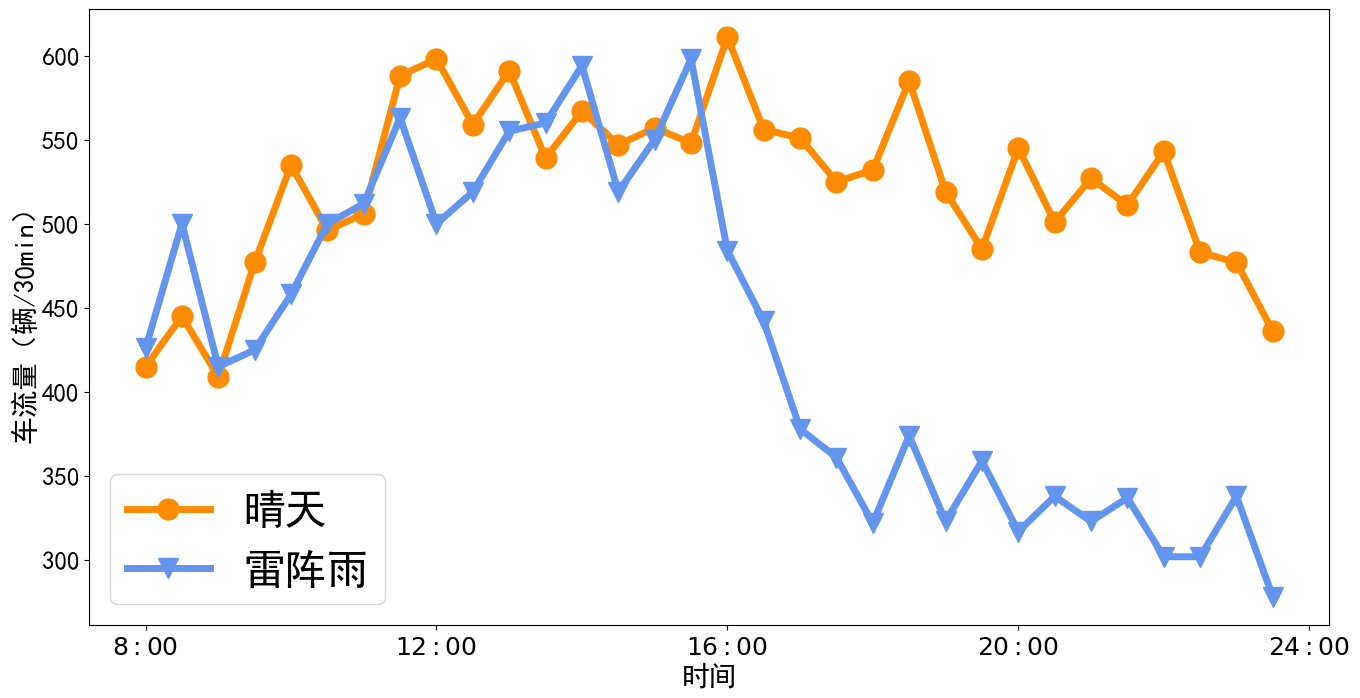

In [19]:
import matplotlib.pyplot as plt
def inverse_transform(X):
    X = (X + 1.) / 2.
    X = 1. * X * (1292 - 0) + 0
    return X
# timestamps = np.array(timestamps)
# print(timestamps[13350])
train_y = np.load('../data_process/data/TaxiBJ633补充版/train_y.npy')
true = []
for i in range(len(train_y)):
    true.append(train_y[i][0][11][23])
y = [inverse_transform(d) for d in true]
for i,cont in enumerate(y):
    if cont<50:
        print(i)
        print(cont)
plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['font.sans-serif']=['Times New Roman'] 
plt.figure(figsize=(16,8))
plt.plot(y[867:899],'o',markersize=15, color='darkorange',linewidth=5,linestyle = '-',label='晴天')
plt.plot(y[531:563],'v', markersize=15,color='cornflowerblue',linewidth=5,linestyle = '-',label='雷阵雨')
plt.xticks([0,8,16,24,32],[ '$8:00$','$12:00$',
                                        '$16:00$','$20:00$','$24:00$'],fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("时间",fontsize=20,weight='bold')
plt.ylabel("车流量（辆/30min）",weight='bold',fontsize=20)
plt.legend(loc='best',fontsize=30)
# plt.savefig("晴天雨天liul对比.jpg",dpi=300,format='jpg')
plt.show()
# plt.xticks(list1,timestamps[500:600],fontsize=25)

In [213]:
fname=os.path.join(DATAPATH, 'BJ_Meteorology.h5')
fname = os.path.join(
            DATAPATH, 'BJ{}_M32x32_T30_InOut.h5'.format(13))
f = h5py.File(fname, 'r')
# Weather = f['Weather'][()]
# Timeslot = f['date'][()]
data = f['data'][:]
print(timestamps[1])
for i in timestamps:
    if i[:8] == b'20160209':
        timestamps = np.delete(timestamps, np.where(timestamps == i))

print(len(timestamps))
# print(Timeslot[52085])
# print(Weather[52085])

b'2013071209'
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [184]:
if __name__ == "__main__":
    load_dataset(c_length=6, p_length=1, t_length=1, test_len=28 * 48, val_len=28 * 48)

file name:  data/BJ13_M32x32_T30_InOut.h5
==========stat==========
data shape: (4888, 2, 32, 32)
# of days: 121, from 2013-07-01 to 2013-10-29
# of timeslots: 5808
# of timeslots (available): 4888
missing ratio of timeslots: 15.8%
max: 1230.000, min: 0.000
==========stat==========
[b'2013070101' b'2013070102' b'2013070103' ... b'2013102946' b'2013102947'
 b'2013102948']
incomplete days:  [b'20130926']


file name:  data/BJ14_M32x32_T30_InOut.h5
==========stat==========
data shape: (4780, 2, 32, 32)
# of days: 119, from 2014-03-01 to 2014-06-27
# of timeslots: 5712
# of timeslots (available): 4780
missing ratio of timeslots: 16.3%
max: 1292.000, min: 0.000
==========stat==========
[b'2014030101' b'2014030102' b'2014030103' ... b'2014062722' b'2014062723'
 b'2014062724']
incomplete days:  [b'20140304', b'20140313', b'20140323', b'20140326', b'20140401', b'20140402', b'20140409', b'20140410', b'20140412', b'20140422', b'20140501', b'20140526', b'20140618', b'20140627']


file name:  data/

KeyboardInterrupt: 

In [5]:
def create_dataset(self, c_length=3, t_length=3, t_inter=7, p_length=3, p_inter=1):
        offset_frame = pd.DateOffset(minutes=24 * 60 // self.T)  # 时间偏移 minutes = 30
        C_list = []
        P_list = []
        T_list = []
        Y_list = []
        timestamps_Y = []
        time_range = [range(1, c_length + 1),
                      [48],
#                       [p_inter * self.T * j-1,p_inter * self.T * j,p_inter * self.T * j+1 for j in range(1, p_length +1)],
                      [t_inter * self.T * j for j in range(1, t_length + 1)]]

        # print depends # [range(1, 4), [48, 96, 144], [336, 672, 1008]]
        bound = max(self.T * t_inter * t_length, self.T * p_inter * p_length+1, c_length)
        while bound < len(self.pd_timestamps):
            Flag = True
            for branch in time_range:
                if Flag is False:
                    break
                Flag = self.check_it([self.pd_timestamps[bound] - j * offset_frame for j in branch])

            if Flag is False:
                bound += 1
                continue
            x_c = [self.get_matrix(self.pd_timestamps[bound] - j * offset_frame) for j in time_range[0]]
            # 取当前时刻的前3个时间片的数据数据构成“邻近性”模块中一个输入序列
            # 例如当前时刻为[Timestamp('2013-07-01 00:00:00')]
            # 则取：
            # [Timestamp('2013-06-30 23:30:00'), Timestamp('2013-06-30 23:00:00'), Timestamp('2013-06-30 22:30:00')]
            #  三个时刻所对应的in-out flow为一个序列
            x_p = [self.get_matrix(self.pd_timestamps[bound] - j * offset_frame) for j in time_range[1]]
            # 取当前时刻 前 1*PeriodInterval,2*PeriodInterval,...,len_period*PeriodInterval
            # 天对应时刻的in-out flow 作为一个序列，例如按默认值为 取前1、2、3天同一时刻的In-out flow
            x_t = [self.get_matrix(self.pd_timestamps[bound] - j * offset_frame) for j in time_range[2]]
            # 取当前时刻 前 1*TrendInterval,2*TrendInterval,...,len_trend*TrendInterval
            # 天对应时刻的in-out flow 作为一个序列,例如按默认值为 取 前7、14、21天同一时刻的In-out flow
            y = self.get_matrix(self.pd_timestamps[bound])
            if c_length > 0:
                C_list.append(np.vstack(x_c))
                # a.shape=[2,32,32] b.shape=[2,32,32] c=np.vstack((a,b)) -->c.shape = [4,32,32]
            if p_length > 0:
                P_list.append(np.vstack(x_p))
            if t_length > 0:
                T_list.append(np.vstack(x_t))
            Y_list.append(y)
            timestamps_Y.append(self.timestamps[bound])#[]
            bound += 1
        XC = np.asarray(C_list)  # 模拟 邻近性的 数据 [?,6,32,32]
        XP = np.asarray(P_list)  # 模拟 周期性的 数据 隔天
        XT = np.asarray(T_list)  # 模拟 趋势性的 数据 隔周
        Y = np.asarray(Y_list)# [?,2,32,32]
        print("XC shape: ", XC.shape, "XP shape: ", XP.shape, "XT shape: ", XT.shape, "Y shape:", Y.shape)
        return XC, XP, XT, Y, timestamps_Y

In [62]:
def load_dataset1(T=48, flow_channel=2, c_length=None,
                 p_length=None, t_length=None, test_len=None, val_len=None, 
                 meta_data=True,meteorol_data=True, holiday_data=True):
    #assert (len_closeness + len_period + len_trend > 0)
    # load data
    # 13 - 16
    data_all = []
    timestamps_all = []
    for year in range(13, 17):
        fname = os.path.join(
            DATAPATH, 'BJ{}_M32x32_T30_InOut.h5'.format(year))
#         print("file name: ", fname)
#         stat(fname)
        data, timestamps = load_stdata(fname)
        data, timestamps = remove_incomplete_days(data, timestamps, T)
        data[data < 0] = 0.
        data_all.append(data)
        timestamps_all.append(timestamps)
        print("\n")

    # minmax_scale
    data_train = np.vstack(copy(data_all))
    print('train_data shape: ', data_train.shape)
        # remove a certain day which does not have 48 timestamps
     
    return timestamps_all,data_train

timestamps_Y,data =  load_dataset1(c_length=3, p_length=1, t_length=1, test_len=28 * 48, val_len=28 * 48)

incomplete days:  [b'20130926']


incomplete days:  [b'20140304', b'20140313', b'20140323', b'20140326', b'20140401', b'20140402', b'20140409', b'20140410', b'20140412', b'20140422', b'20140501', b'20140526', b'20140618', b'20140627']


incomplete days:  [b'20150320', b'20150404', b'20150620']


incomplete days:  [b'20151101', b'20151103', b'20151109', b'20151110', b'20151112', b'20151121', b'20151124', b'20151128', b'20151201', b'20151203', b'20151206', b'20151210', b'20151211', b'20151212', b'20151217', b'20151227', b'20151229', b'20160111', b'20160127', b'20160323', b'20160410']


train_data shape:  (21360, 2, 32, 32)


In [42]:
# timestamps_Y = np.array(timestamps_Y)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12344\729932010.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  timestamps_Y = np.array(timestamps_Y)


In [56]:
#获取对应时间
timestamps_Y = np.load('BikeNYC_timestamp.npy')
timestamps_Y.shape
serise = np.load('BikeNYCspace_KMedids.npy')
print(serise.shape)
k_means = []
timestamps = []
for i,slot in enumerate(timestamps_Y):
    time = str(slot[:], encoding="utf-8") 
#     print(time)
#     time = datetime.strptime(time, '%Y%m%d')
#     print(time)
    timestamps.append(time)
for i in timestamps:
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==0 and datetime.strptime(i[:8], "%Y%m%d") not in us_holidays:
        k_means.append(serise[:,int(i[8:])-1])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==1 and datetime.strptime(i[:8], "%Y%m%d") not in us_holidays:
        k_means.append(serise[:,int(i[8:])+23])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==2 and datetime.strptime(i[:8], "%Y%m%d") not in us_holidays:
        k_means.append(serise[:,int(i[8:])+47])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==3 and datetime.strptime(i[:8], "%Y%m%d") not in us_holidays:
        k_means.append(serise[:,int(i[8:])+71])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==4 and datetime.strptime(i[:8], "%Y%m%d") not in us_holidays:
        k_means.append(serise[:,int(i[8:])+95])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==5:
        k_means.append(serise[:,int(i[8:])+119])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==6: 
        k_means.append(serise[:,int(i[8:])+143])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==0 and datetime.strptime(i[:8], "%Y%m%d")  in us_holidays:
        k_means.append(serise[:,int(i[8:])+119])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==1 and datetime.strptime(i[:8], "%Y%m%d") in us_holidays:
        k_means.append(serise[:,int(i[8:])+119])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==2 and datetime.strptime(i[:8], "%Y%m%d") in us_holidays:
        k_means.append(serise[:,int(i[8:])+119])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==3 and datetime.strptime(i[:8], "%Y%m%d") in us_holidays:
        k_means.append(serise[:,int(i[8:])+119])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==4 and datetime.strptime(i[:8], "%Y%m%d") in us_holidays:
        k_means.append(serise[:,int(i[8:])+119])
k_means = np.array(k_means)
print(k_means.shape)
np.save('BikeNYC_pattern',k_means)

(6, 168)
(4223, 6)


In [7]:
# timestamps_Y = pd.DataFrame(timestamps_Y)'
k_means = []
timestamps = []
for i,slot in enumerate(timestamps_Y):
    time = str(slot[:], encoding="utf-8") 
#     print(time)
#     time = datetime.strptime(time, '%Y%m%d')
#     print(time)
    timestamps.append(time)
for i in timestamps:
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==0 and  is_holiday(datetime.strptime(i[:8], "%Y%m%d")) is False:
        k_means.append(serise[:,int(i[8:])-1])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==1 and is_holiday(datetime.strptime(i[:8], "%Y%m%d")) is False:
        k_means.append(serise[:,int(i[8:])+47])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==2 and is_holiday(datetime.strptime(i[:8], "%Y%m%d")) is False:
        k_means.append(serise[:,int(i[8:])+95])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==3 and is_holiday(datetime.strptime(i[:8], "%Y%m%d")) is False:
        k_means.append(serise[:,int(i[8:])+143])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==4 and is_holiday(datetime.strptime(i[:8], "%Y%m%d")) is False:
        k_means.append(serise[:,int(i[8:])+191])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==5:
        k_means.append(serise[:,int(i[8:])+239])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==6: 
        k_means.append(serise[:,int(i[8:])+287])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==0 and is_holiday(datetime.strptime(i[:8], "%Y%m%d")) is True:
        k_means.append(serise[:,int(i[8:])+239])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==1 and is_holiday(datetime.strptime(i[:8], "%Y%m%d")) is True:
        k_means.append(serise[:,int(i[8:])+239])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==2 and is_holiday(datetime.strptime(i[:8], "%Y%m%d")) is True:
        k_means.append(serise[:,int(i[8:])+239])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==3 and is_holiday(datetime.strptime(i[:8], "%Y%m%d")) is True:
        k_means.append(serise[:,int(i[8:])+239])
    if datetime.strptime(i[:8], "%Y%m%d").weekday()==4 and is_holiday(datetime.strptime(i[:8], "%Y%m%d")) is True:
        k_means.append(serise[:,int(i[8:])+239])
print(len(k_means))       

(6, 336)


NameError: name 'timestamps_Y' is not defined

In [45]:
np.save('k-means.npy',k_means)

In [29]:
all_data = np.load('BikeNYC_all.npy')
all_time = np.load('BikeNYC_timestamp.npy')

In [30]:
all_data = all_data.reshape(4392,2,16,8)
all_data = np.mean(all_data,axis = 1)
all_time = all_time.reshape(4392)

In [31]:
timestamps = []
for i,slot in enumerate(all_time):
    time = str(slot[:8], encoding="utf-8")
    time = datetime.strptime(time, '%Y%m%d')
    timestamps.append(time)
# week_mean = np.save("week_mean.npy",week_mean)

In [32]:
from datetime import datetime
from chinese_calendar import is_workday, is_holiday,get_holiday_detail,is_in_lieu
import holidays
week=timestamps[48].weekday()
us_holidays = holidays.UnitedStates()
c = 0
for i in timestamps:
    if i in us_holidays:
        c+=1
print(c)

72


In [34]:
# print(holiday)
# print(week)

In [35]:
Monday = []
Tuesday = []
Wednesday = []
Thirsday = []
Friday =[]
Saturday = []
Sunday = []
holiday = []
for i,traffic in enumerate(all_data):
    if timestamps[i].weekday() ==0 and timestamps[i] not in us_holidays:
        Monday.append(traffic)
    if timestamps[i].weekday() ==1 and timestamps[i] not in us_holidays:
        Tuesday.append(traffic)
    if timestamps[i].weekday() ==2 and timestamps[i] not in us_holidays:
        Wednesday.append(traffic)
    if timestamps[i].weekday() ==3 and timestamps[i] not in us_holidays:
        Thirsday.append(traffic)
    if timestamps[i].weekday() ==4 and timestamps[i] not in us_holidays:
        Friday.append(traffic)
    if timestamps[i].weekday() ==5:
        Saturday.append(traffic)
    if timestamps[i].weekday() ==6:
        Sunday.append(traffic)
    if timestamps[i]  in us_holidays and timestamps[i].weekday()!=6 and timestamps[i].weekday()!=5:
        holiday.append(traffic)

In [37]:
Monday = np.array(Monday)
print(Monday.shape)
Tuesday = np.array(Tuesday)
print(Tuesday.shape)
Wednesday = np.array(Wednesday)
print(Wednesday.shape)
Thirsday = np.array(Thirsday)
print(Thirsday.shape)
Friday =np.array(Friday)
print(Friday.shape)
Saturday = np.array(Saturday)
print(Saturday.shape)
Sunday = np.array(Sunday)
print(Sunday.shape)
holiday = np.array(holiday)
print(holiday.shape)

(576, 16, 8)
(648, 16, 8)
(624, 16, 8)
(624, 16, 8)
(600, 16, 8)
(624, 16, 8)
(624, 16, 8)
(72, 16, 8)


In [168]:
#TaxiBJ_week_dispose
Monday = Monday.reshape(58,48,32,32)
Monday = np.mean(Monday,axis=0)
Tuesday = Tuesday.reshape(62,48,32,32)
Tuesday = np.mean(Tuesday,axis=0)
Wednesday = Wednesday.reshape(56,48,32,32)
Wednesday = np.mean(Wednesday,axis=0)
Thirsday = Thirsday.reshape(60,48,32,32)
Thirsday = np.mean(Thirsday,axis=0)
Friday = Friday.reshape(61,48,32,32)
Friday = np.mean(Friday,axis=0)
Saturday = Saturday.reshape(59,48,32,32)
Saturday = np.mean(Saturday,axis=0)
Sunday = Sunday.reshape(69,48,32,32)
Sunday = np.mean(Sunday,axis=0)

In [39]:
#BikeNYC_week_dispose
Monday = Monday.reshape(24,24,16,8)
Monday = np.mean(Monday,axis=0)
Tuesday = Tuesday.reshape(27,24,16,8)
Tuesday = np.mean(Tuesday,axis=0)
Wednesday = Wednesday.reshape(26,24,16,8)
Wednesday = np.mean(Wednesday,axis=0)
Thirsday = Thirsday.reshape(26,24,16,8)
Thirsday = np.mean(Thirsday,axis=0)
Friday = Friday.reshape(25,24,16,8)
Friday = np.mean(Friday,axis=0)
Saturday = Saturday.reshape(26,24,16,8)
Saturday = np.mean(Saturday,axis=0)
Sunday = Sunday.reshape(26,24,16,8)
Sunday = np.mean(Sunday,axis=0)

In [41]:
week_mean = np.concatenate((Monday,Tuesday,Wednesday,Thirsday,Friday,Saturday,Sunday),axis=0)

In [50]:
np.save('BikeNYC_weekmean.npy',week_mean)